# Generate the data
Downloads the poster images and saved a new csv file with the data

In [ ]:
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

In [ ]:
import pandas as pd 
# Read data from file 'MovieGenre.csv' 
poster_data = pd.read_csv(poster_data_path, encoding = "ISO-8859-1", usecols=['imdbId', 'Genre', 'Title', 'Poster']) 

# Preview the first 5 lines of the loaded data 
poster_data.head()

In [ ]:
len(poster_data)

Remove lines with empty cells

In [ ]:
import numpy as np
cols=['imdbId', 'Genre', 'Title', 'Poster']
for i in cols:
    poster_data[i].replace('', np.nan, inplace=True)
for i in cols:
    poster_data.dropna(subset=[i], inplace=True)
    
len(poster_data)

### Download movie posters
Check if the poster has a valid url. If the poster is found, download it and save the movie titles and genres to a new file. If the image is already downloaded and found in the folder, the download is skipped.

In [ ]:
import urllib.request
from urllib.error import HTTPError
import os.path

def download_posters(poster_url, path, title):
    if os.path.isfile(path+".jpg"):
        print ("Poster", title ,"exist")
    else:
        try:
            urllib.request.urlretrieve(poster_url, path+".jpg")
        except HTTPError:
            print("Movie",title ,"poster not found!")
            return False
    return True

In [ ]:
import re

new_poster_data = pd.DataFrame(columns=['imgid', 'title', 'genres'])

for _, row in poster_data.iterrows(): 
    genre = str(row['Genre'])
    genres = str(row['Genre']).split("|")
    genres = (", ").join(genres)
    title = str(row['Title'])
    img_id = str(row['imdbId'])    
    # remove years from titles
    title = re.sub(" \(\d{4,}\)", "",  title)
    poster_url = str(row['Poster'])
    
    # download the poster
    poster = download_posters(poster_url, base_images_path+img_id, title)
    
    not_found = 0
    # if poster is not found, skip movie
    if poster == True:
        new_row = {'imgid':img_id ,'title':title, 'genres':genres}    
        new_poster_data = new_poster_data.append(new_row, ignore_index=True) 
    else:
        not_found += 1

print("{} posters not found".format(not_found))

In [ ]:
new_poster_data.head()

In [ ]:
new_poster_data.to_csv(data_path+new_poster_data_file,index=False)

## Start vectorization (run from here after downloading img)

In [86]:
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

In [87]:
import pandas as pd 
# Read data from file 'MovieGenre.csv' 
new_poster_data = pd.read_csv(data_path+new_poster_data_file, encoding = "ISO-8859-1", usecols=['imgid', 'title', 'genres']) 

# Preview the first 5 lines of the loaded data 
new_poster_data.head()

,imgid,title,genres
0,114709,Toy Story,"Animation, Adventure, Comedy"
1,113497,Jumanji,"Action, Adventure, Family"
2,113228,Grumpier Old Men,"Comedy, Romance"
3,114885,Waiting to Exhale,"Comedy, Drama, Romance"
4,113041,Father of the Bride Part II,"Comedy, Family, Romance"


In [88]:
len(new_poster_data)

37742

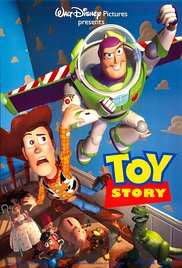

In [89]:
from IPython.display import Image
image = Image(base_images_path+'/114709.jpg')
image

## Movie title tokenization

In [90]:
from bpemb import BPEmb

If/how a word gets split depends on the vocabulary size. Generally, a smaller vocabulary size will yield a segmentation into many subwords, while a large vocabulary size will result in frequent words not being split. The advantage of having few operations is that this results in a smaller vocabulary of symbols. You need less data to learn representations (embeddings) of these symbols. The disadvantage is that you need data to learn how to compose those symbols into meaningful units (e.g. words).
I chose the smallest vocabulary since the larger ones would not split any titles at all.

In [91]:
#bpemb_en = BPEmb(lang="en", dim=300, vs=100000)
bpemb_en = BPEmb(lang="en", dim=100, vs=1000)

In [92]:
bpemb_en.encode("Toy Story")

['▁to', 'y', '▁st', 'ory']

In [93]:
# look at some examples
for _,row in new_poster_data[:10].iterrows():

    title = str(row['title'])
    print(title, bpemb_en.encode(title))

Toy Story ['▁to', 'y', '▁st', 'ory']
Jumanji ['▁j', 'um', 'an', 'j', 'i']
Grumpier Old Men ['▁gr', 'um', 'p', 'ier', '▁old', '▁m', 'en']
Waiting to Exhale ['▁w', 'a', 'it', 'ing', '▁to', '▁ex', 'h', 'ale']
Father of the Bride Part II ['▁f', 'ather', '▁of', '▁the', '▁br', 'ide', '▁part', '▁i', 'i']
Heat ['▁he', 'at']
Sabrina ['▁s', 'ab', 'r', 'ina']
Sudden Death ['▁s', 'ud', 'd', 'en', '▁de', 'ath']
GoldenEye ['▁g', 'old', 'en', 'e', 'y', 'e']
The American President ['▁the', '▁american', '▁pres', 'ident']


In [94]:
bpemb_en.most_similar("ory")

[('▁hist', 0.6690595149993896),
 ('ict', 0.6023141741752625),
 ('ical', 0.45034170150756836),
 ('raph', 0.42858463525772095),
 ('rit', 0.4229355454444885),
 ('ics', 0.40942496061325073),
 ('▁book', 0.39245858788490295),
 ('the', 0.3671647906303406),
 ('or', 0.35785210132598877),
 ('▁art', 0.3448060154914856)]

In [95]:
def generate_embeddings(movie_title):
    #ids = bpemb_en.encode_ids(movie_title)
    #emb = bpemb_en.vectors[ids].shape
    emb = bpemb_en.embed(movie_title)
    return emb

In [96]:
emb = generate_embeddings("Grumpier Old Men")
emb.shape

(7, 100)

## Get image feature vectors

In [97]:
import torch
data_path = "../data/"
poster_data_path = data_path + "movie-genre-from-its-poster/MovieGenre.csv"
new_poster_data_file = "New_poster_data.csv"
base_images_path = "../data/images/100/"

model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet34', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet50', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet101', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet152', pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

Using cache found in /home/gusihaliel@GU.GU.SE/.cache/torch/hub/pytorch_vision_v0.4.2


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [98]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#scaler = transforms.Scale((224, 224))
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

to_tensor = transforms.ToTensor()

def get_img_vector(image_name):
    # Load the image with Pillow library
    img = Image.open(image_name)    
    # Check if the img is in colour
    img_bands = img.getbands()    
    
    if img_bands != ('R', 'G', 'B'):
        img = img.convert("RGB")
    # Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))          
    #  Create a vector of zeros that will hold the feature vector
    #  The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        #my_embedding.copy_(o.data) # original code not working
        my_embedding.copy_(o.data.squeeze())        
    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        t_img = t_img.to(device)
        model.to(device)
    #  Attach that function to our selected layer   
    h = layer.register_forward_hook(copy_data)    
    #  Run the model on our transformed image
    model(t_img)    
    #  Detach our copy function from the layer
    h.remove()
    #  Return the feature vector
    return my_embedding


In [99]:
def preprocess_batch_imgs(image_names):
    list_of_tensors = [
        get_img_vector(image_name)
        for image_name in image_names
    ]
    return list_of_tensors

In [100]:
idxs = bpemb_en.encode_ids("Toy Story")
print(idxs)
bpemb_en.decode_ids(idxs)

[42, 933, 66, 325]


'toy story'

 ### Create the dataset
 The dataset contains the movie titles and a list of each token in the title, concatenated with the image vector.


In [101]:
import numpy as np
# save the processed images to disk 
list_of_img_embs = np.load('list_of_img_embs.npy')

In [102]:
from torch.utils.data import Dataset
from torch.utils import data

class MoviePosterDataset(Dataset):
    def __init__(self, poster_data, img_vectors):
        self.titles = [str(row['title']) for _,row in poster_data.iterrows()]
        self.img_vectors = img_vectors      

    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):
        img_vector = self.img_vectors[idx]
        title = self.titles[idx]
        
        return title, img_vector

In [103]:
# create the dataset
movies_dataset = MoviePosterDataset(new_poster_data, list_of_img_embs)

## Split into training, testing and validation sets

In [104]:
import random
import math
torch.random.seed()

totalindices = list(range(len(movies_dataset)))
random.shuffle(totalindices)
splitindex = math.floor(len(movies_dataset)*0.6)
trainindices = totalindices[:splitindex]
testindices_ = totalindices[splitindex:]
splitindex2 = math.floor(len(testindices_)*0.5)
testindices = testindices_[:splitindex2]
valindices = testindices_[splitindex2:]

In [105]:
trainingsampler = torch.utils.data.SubsetRandomSampler(trainindices)
testingsampler = torch.utils.data.SubsetRandomSampler(testindices)
validationsampler = torch.utils.data.SubsetRandomSampler(valindices)

In [106]:
print(f'Number of training examples: {len(trainingsampler)}')
print(f'Number of validation examples: {len(validationsampler)}')
print(f'Number of testing examples: {len(testingsampler)}')

Number of training examples: 22645
Number of validation examples: 7549
Number of testing examples: 7548


In [107]:
batches = 32

In [108]:
traindl = torch.utils.data.DataLoader(movies_dataset, batch_size=batches, 
                                      sampler=trainingsampler, pin_memory=False)
valdl = torch.utils.data.DataLoader(movies_dataset, batch_size=batches, sampler=validationsampler, pin_memory=False)
testdl = torch.utils.data.DataLoader(movies_dataset, sampler=testingsampler)

## Build the model

In [109]:
# define image dimensions
img_dim = list_of_img_embs[1].shape[0]

In [164]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class TitleModel(nn.Module):
    def __init__(self, device, bpemb_xx, img_dim):
        super().__init__()
        self.device = device
        self.hidden_size = 128 #bpemb_xx.dim
        self.output_size = bpemb_xx.vocab_size + 1        
        self.emb_size = bpemb_xx.dim + img_dim        
        self.title_embedding = nn.Embedding.from_pretrained(torch.tensor(bpemb_xx.vectors))
        self.title_embedding.weight.requires_grad=False
        self.gru = nn.GRUCell(self.emb_size, self.hidden_size)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, title_seqs, img_vecs):
        # title_seqs a list of token idx, batch first.
        #inp = [self.title_embedding(torch.tensor(title_seq)) for title_seq in title_seqs] # CUDA error here
        # could create tensor directly on CPU but would raise exception if GPU is used
        inp = []
        for title_seq in title_seqs:
            t = torch.tensor(title_seq)
            t = t.to(device)
            ts = self.title_embedding(t)
            inp.append(ts)
            
        inp = torch.nn.utils.rnn.pad_sequence(inp) # batch second!     
        batch_size = inp.size()[1]
        # concat start token <s> zero-vector here:
        s_vecs = torch.zeros((1, batch_size, inp.size()[2])) # <seq, batch, dim>         
        s_vecs = s_vecs.to(device)
        inp = inp.to(device)        
        inp = torch.cat([s_vecs, inp], dim=0) # <seq, batch, dim>        
        seq_len = inp.size()[0]      
        outputs = []
        predictions = []
        # init the first first state before start:
        h_prev = torch.zeros((batch_size, self.hidden_size)).float()
        
        for i in range(seq_len):
            inp_i =inp[i].to(device)
            img_vecs = img_vecs.to(device)            
            x = torch.cat([inp[i], img_vecs], 1) # batch first   
            x=x.to(device)
            h_prev=h_prev.to(device)
            h = self.gru(x, h_prev)
            logits = self.decoder(h)
            outputs.append(logits)
            predictions.append(self.softmax(logits))
            
        # concatenate the output list
        output = torch.cat(outputs, dim=0) # <seq * batch, dim>
       
        return output, predictions


In [165]:
model = TitleModel(device, bpemb_en, img_dim)

In [166]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 414,057 trainable parameters


In [167]:
test_idx = bpemb_en.encode_ids(["Toy Story", "Jumanji"])
emb_l = nn.Embedding.from_pretrained(torch.tensor(bpemb_en.vectors))
x = torch.nn.utils.rnn.pad_sequence([emb_l(torch.tensor(t)) for t in test_idx])
x.size(), x[1].size(), x[:, 0].size()

(torch.Size([5, 2, 100]), torch.Size([2, 100]), torch.Size([5, 100]))

## Training

In [171]:
epochs = 1000
learning_rate= 0.005
criterion = nn.CrossEntropyLoss(ignore_index=bpemb_en.vocab_size, reduction='sum') # ignore the last token in vocab
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion=criterion.to(device)

In [172]:
def train_model(model, epochs):
    model = model.to(device)
    training_losses = []
    validation_losses_poster = []
    validation_losses_no_poster = []
    best_val_loss = 0.0
    
    for e in range(epochs):
        model.train()

        train_loss = 0.0        
        training_tokens = 0

        for titles, img_vectors in traindl:     
            title_seqs = bpemb_en.encode_ids(titles) # length of batch size
            #something like `x = (title_seqs, img_vectors)`
            count_tokens = sum(1 for seq in title_seqs for _ in idxs)
            training_tokens += count_tokens
            y = [torch.tensor(title_idxs+[bpemb_en.vocab_size]) for title_idxs in title_seqs] 
            y = torch.nn.utils.rnn.pad_sequence(y, padding_value=bpemb_en.vocab_size) # batch second! 
            y=y.to(device)
            y = y.view(-1)

            optimizer.zero_grad()        

            output,_= model(title_seqs, img_vectors)            
            loss = criterion(output, y) # predictions, true
            train_loss+=loss.item()

            loss.backward()
            optimizer.step()
        
        # Validation
        val_loss_poster = 0.0
        val_loss_no_poster = 0.0
        validation_tokens = 0

        for titles, img_vectors in valdl:
            model.eval()
            title_seqs = bpemb_en.encode_ids(titles) # length of batch size
            #something like `x = (title_seqs, img_vectors)`
            count_tokens = sum(1 for seq in title_seqs for _ in idxs)
            validation_tokens += count_tokens
            y = [torch.tensor(title_idxs+[bpemb_en.vocab_size]) for title_idxs in title_seqs] 
            y = torch.nn.utils.rnn.pad_sequence(y, padding_value=bpemb_en.vocab_size) 
            y=y.to(device)
            y = y.view(-1)

            output,_= model(title_seqs, img_vectors)
            loss_poster = criterion(output, y)
            val_loss_poster+=loss_poster.item()
            
            output_2,_= model(title_seqs, torch.zeros_like(img_vectors)) # fake poster
            loss_no_poster = criterion(output_2, y)
            val_loss_no_poster+=loss_no_poster.item()
            
        
        total_val_loss_poster = val_loss_poster/validation_tokens
        total_val_loss_no_poster = val_loss_no_poster/validation_tokens
        total_training_loss = train_loss/training_tokens
        
        # save best model
        if e == 0:
            best_val_loss = val_loss_poster        
        if val_loss_poster < best_val_loss:
            best_val_loss = val_loss_poster
            torch.save(model.state_dict(), "language_model")
        
        training_losses.append(total_training_loss)
        validation_losses_poster.append(total_val_loss_poster)
        validation_losses_no_poster.append(total_val_loss_no_poster)
        
        print(f"Epoch: {e+1}")
        print(f"Validation loss without image: {total_val_loss_no_poster:0.3f}")
        print(f"Validation loss with image: {total_val_loss_poster:0.3f}")
        print(f"Training loss: {total_training_loss:0.3f}")
        print("--"*20)
    
    return training_losses, validation_losses_poster, validation_losses_no_poster
        

In [173]:
training_losses, validation_losses_poster, validation_losses_no_poster = train_model(model, epochs)

Epoch: 1
Validation loss without image: 98.449
Validation loss with image: 10.738
Training loss: 9.696
----------------------------------------
Epoch: 2
Validation loss without image: 99.113
Validation loss with image: 10.668
Training loss: 9.657
----------------------------------------
Epoch: 3
Validation loss without image: 100.177
Validation loss with image: 10.795
Training loss: 9.658
----------------------------------------
Epoch: 4
Validation loss without image: 101.941
Validation loss with image: 10.786
Training loss: 9.644
----------------------------------------
Epoch: 5
Validation loss without image: 102.785
Validation loss with image: 10.646
Training loss: 9.642
----------------------------------------
Epoch: 6
Validation loss without image: 105.425
Validation loss with image: 10.793
Training loss: 9.634
----------------------------------------
Epoch: 7
Validation loss without image: 104.788
Validation loss with image: 10.842
Training loss: 9.624
----------------------------

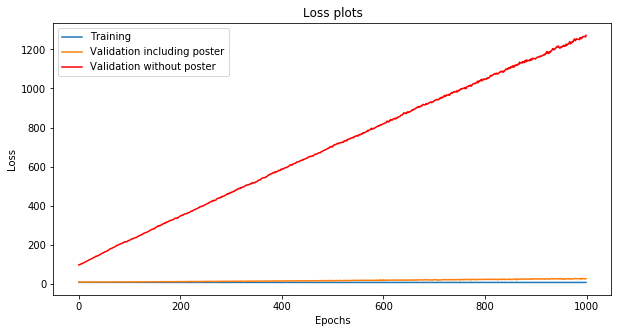

In [176]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(training_losses, label="Train")
plt.plot(validation_losses_poster,label="Poster")
plt.plot(validation_losses_no_poster,color='red',label="No poster")
plt.legend(['Training', 'Validation including poster', 'Validation without poster'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plots")

plt.show()

In [ ]:
def test_model(model, testdl):
    model.eval()
    for titles, img_vectors in testdl:
        title_seqs = bpemb_en.encode_ids(titles) 
            count_tokens = sum(1 for seq in title_seqs for _ in idxs)
            validation_tokens += count_tokens
            y = [torch.tensor(title_idxs+[bpemb_en.vocab_size]) for title_idxs in title_seqs] 
            y = torch.nn.utils.rnn.pad_sequence(y, padding_value=bpemb_en.vocab_size) # batch second! 
            y=y.to(device)
            y = y.view(-1)

            output, _  = model(title_seqs, img_vectors)
            output_2, _ = model(title_seqs, torch.zeros_like(img_vectors)) # fake poster
            loss_poster = criterion(output, y) # predictions, true
            loss_no_poster = criterion(output_2, y)
    